In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

## Per Region Business As Usual Case

### Read in Data

In [2]:
df = pd.read_csv('../data/data_kern.csv')
eco_service_cols = df.columns[-13:]
df.head()

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,HabCorridors,ConservationAreas,ImpBirdAreas,Nitrate,ModSAGBI,Prox2Wetlands,Depth2GroundWater
0,45,70.791382,AlfalfaandAlfalfaMixtures,78836.822440,359.620220,12283.604020,100.0,100.0,0.0,94.0,0.0,100.0,0.0,0.000000,42.0,0.0,20.0
1,72,81.343317,AlfalfaandAlfalfaMixtures,90587.985160,413.224051,1975.754272,100.0,100.0,100.0,0.0,0.0,100.0,0.0,100.000000,0.0,100.0,5.0
2,91,28.286742,AlfalfaandAlfalfaMixtures,31501.529700,143.696647,3311.302980,100.0,100.0,0.0,0.0,0.0,46.0,91.0,93.333333,98.0,0.0,20.0
3,116,6.073612,AlfalfaandAlfalfaMixtures,6763.878538,30.853951,417.364790,100.0,100.0,0.0,0.0,0.0,100.0,0.0,83.333333,75.5,0.0,11.5
4,143,97.932855,AlfalfaandAlfalfaMixtures,109062.924200,497.498904,11437.290070,100.0,100.0,4.0,0.0,83.0,100.0,0.0,0.000000,97.0,100.0,20.0


#### Compare inputs to PPIC report
|Region|Land (1,000s acres)|Applied Water (1,000s of acre-ft)|Revenue (2010 $, millions)|
|--------------------------|---------------------------------|--------------------------|
|KR\

In [32]:
total_revenue = df['FieldCropPrice'].sum()
print (f'${total_revenue:,.2f} in annual revenue')

$7,298,194,072.79 in annual revenue


In [33]:
cropland = df['Area'].sum()
print(f'{cropland:,.0f} acres of cropland')

856,945 acres of cropland


In [34]:
applied_water = df['SavedWater'].sum()
print (f'{applied_water:,.0f} acre-feet of applied water')

2,844,471 acre-feet of applied water


In [3]:
crop_x = pd.read_csv('../data/crop_x.csv')
crop_x.head()

,Crop,Crop_PPIC
0,AlfalfaandAlfalfaMixtures,alfalfa-pasture
1,Almonds,trees-vines
2,Apples,veg-fruits
3,Avocados,veg-fruits
4,Beans(Dry),field-crops-grains


In [4]:
targets = pd.read_csv('../data/targets.csv', index_col='region', thousands=',')
targets

,alfalfa-pasture,corn,field-crops-grains,veg-fruits,trees-vines
region,,,,,
NW,21320.0,8400.0,85920.0,3880.0,3880.0
NE,56850.0,7750.0,23580.0,2260.0,16800.0
SW,36820.0,3880.0,72350.0,8400.0,7750.0
SE,38760.0,16150.0,124030.0,650.0,9690.0
KR,88500.0,54910.0,42640.0,3230.0,11630.0


### Set Up Analysis
#### Cross-walk crop type to PPIC crop type

In [5]:
df = df.join(crop_x.set_index('Crop'), on='Crop')

#### Calculate PricePerAcre column
Will be used to sort crop types within each PPIC crop type to select lowest revenue crops first when fallowing fields

In [6]:
df['PricePerAcre'] = round(df['FieldCropPrice'] / df['Area'],2)

#### Calculate area-weighted ecosystem service values

In [7]:
for eco_service in eco_service_cols[2:]: # exclude Recharge and Saved Water
    new_col = str(eco_service + '_PerAcre')
    df[new_col] = df[eco_service] / 100 * df['Area']

TO DO: Need to confirm that measures are not yet area weighted

### Model Business as Usual Case

In [8]:
# Get list of columns to track for each repetition
outcome_cols = (['Area', 'FieldCropPrice'] 
                + [str(eco_service) for eco_service in eco_service_cols[:2]] 
                + [str(eco_service + '_PerAcre') for eco_service in eco_service_cols[2:]])
outcome_cols

['Area',
 'FieldCropPrice',
 'SavedWater',
 'Recharge',
 'Kitfox_PerAcre',
 'TiptonKRat_PerAcre',
 'GiantGarterSnake_PerAcre',
 'TNC_PerAcre',
 'HabCorridors_PerAcre',
 'ConservationAreas_PerAcre',
 'ImpBirdAreas_PerAcre',
 'Nitrate_PerAcre',
 'ModSAGBI_PerAcre',
 'Prox2Wetlands_PerAcre',
 'Depth2GroundWater_PerAcre']

In [9]:
# specify region, list of crop types, and list of ecosystem service outcomes to track
# set up dataframe to store outcomes of each trial
# for 1000 tries:
#    set up master df (shape = 0 x number of columns of df)
#    for crop in crop type:
#        subset dataset, get target, check that sufficient area is available
#        randomly sort the df
#        subset to meet target
#        append to master df
#    calculate total ecosystem services accumulated and acres faLLowed in master df
#    append outcomes to trials dataframe

region = 'KR'
crop_types = targets.columns
trials = pd.DataFrame(columns=outcome_cols)

for i in range(100):
    df_fallow = pd.DataFrame(columns=df.columns)
    for crop in crop_types:
        df_crop = df[df['Crop_PPIC'] == crop]
        target = targets.loc[region, crop]
        df_crop_shuffle = df_crop.sample(n=df_crop.shape[0])
        df_crop_shuffle.sort_values('PricePerAcre', inplace=True)
        # Identify fields up to target
        df_fallow_bool = df_crop_shuffle['Area'].cumsum() < target
        # Get one additional field by updating value from False to True where 
        # first instance of False is located
        if not df_fallow_bool[df_fallow_bool!=True].empty:
            index = df_fallow_bool[df_fallow_bool!=True].index[0]
            df_fallow_bool.at[index]=True        
        df_crop_fallow = df_crop_shuffle[df_fallow_bool]
        df_fallow = df_fallow.append(df_crop_fallow, ignore_index=True)
    outcomes = pd.DataFrame(df_fallow[outcome_cols].sum()).T
    areas = df_fallow[['Area','Crop_PPIC']].groupby('Crop_PPIC').sum().T
    areas.reset_index(drop=True, inplace=True)
    output = pd.concat([outcomes, areas], axis=1, sort=False)
    trials = trials.append(output, ignore_index=True, sort=False)

In [10]:
trials.head(10)

,Area,FieldCropPrice,SavedWater,Recharge,Kitfox_PerAcre,TiptonKRat_PerAcre,GiantGarterSnake_PerAcre,TNC_PerAcre,HabCorridors_PerAcre,ConservationAreas_PerAcre,ImpBirdAreas_PerAcre,Nitrate_PerAcre,ModSAGBI_PerAcre,Prox2Wetlands_PerAcre,Depth2GroundWater_PerAcre,alfalfa-pasture,corn,field-crops-grains,trees-vines,veg-fruits
0,162066.946622,2.648002e+08,612421.524752,1.431822e+07,161920.160646,142933.613499,53623.205890,26286.340021,4821.419074,110316.843992,33568.796850,122821.585415,64983.793772,90052.508989,24209.926161,80767.856997,23740.216326,42672.892433,11645.006978,3240.973888
1,162126.210343,2.650437e+08,612637.653927,1.428572e+07,161979.424367,143719.580217,54391.349260,26972.764538,4772.183410,110131.779587,33576.170832,122519.839876,64974.326438,91107.377232,24261.936738,80767.856997,23740.216326,42694.083027,11685.091914,3238.962079
2,162053.505913,2.648049e+08,612403.774494,1.427869e+07,161906.719937,142996.294409,53723.963354,26962.435177,4377.541262,110935.726202,34459.375309,122464.574508,65139.247773,90679.675811,24272.733049,80767.856997,23740.216326,42656.332508,11647.548048,3241.552034
3,162132.527742,2.650591e+08,612668.299159,1.423015e+07,161985.741766,142991.671041,53472.174177,26571.515416,4546.288833,111776.132327,34190.320495,123099.980009,64917.390426,91307.876243,24269.273669,80767.856997,23740.216326,42696.605072,11693.430664,3234.418683
4,162157.627826,2.650878e+08,612724.043051,1.425129e+07,162010.841850,143732.184512,53513.675920,26967.337193,4585.705367,111019.349852,34097.105300,123341.971233,65933.194122,90561.305176,24336.819187,80767.856997,23740.216326,42719.751731,11697.375004,3232.427768
5,162060.416350,2.649716e+08,612419.043824,1.428133e+07,161913.630374,142570.928445,53272.094577,26693.657039,4557.730143,110800.757458,34356.958989,122928.368744,65437.070245,90426.886484,24239.072287,80767.856997,23740.216326,42642.989346,11640.789289,3268.564392
6,162070.836525,2.649596e+08,612536.539248,1.434633e+07,161924.050549,142645.530846,53907.658472,26712.994601,4391.670354,111367.575390,34055.950885,122667.907296,64728.009297,91603.113269,24311.103163,80767.856997,23740.216326,42642.566050,11687.598070,3232.599082
7,162309.465403,2.661640e+08,613012.798520,1.436133e+07,162162.679427,142993.782145,53560.162809,26396.794997,4773.586886,111643.137361,33709.874928,122522.567251,65668.948340,91831.704642,24242.107585,80767.856997,23740.216326,42754.426076,11654.298712,3392.667293
8,162071.433653,2.647766e+08,612437.772293,1.425711e+07,161924.647677,142934.981197,54064.937824,26403.919801,4197.515217,110017.433638,33513.656720,122585.603976,65163.966459,90511.068831,24347.261810,80767.856997,23740.216326,42679.728658,11650.052316,3233.579357
9,162069.579342,2.648301e+08,612420.887200,1.428883e+07,161922.793367,142871.285143,54396.792274,25691.362565,4813.481742,109575.245724,33293.990725,122718.244031,64930.159421,90761.839821,24217.204076,80767.856997,23740.216326,42672.875232,11641.075544,3247.555244


#### Save output

In [37]:
outname = '../outputs/' + 'trials' + region +'.xlsx'
trials.to_excel(outname)

### Visualize results

#### Ensure sufficient acreage fallowed

In [26]:
# Average revenue loss
value = trials['FieldCropPrice'].mean()
print (f'${value:,.2f}')

$265,114,542.13


In [11]:
# Bar chart with each crop type on x-axis, acreage fallowed as bars, and targets as dots. Visualize difference between
# acreage fallowed and target for each crop type in one chart.


C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


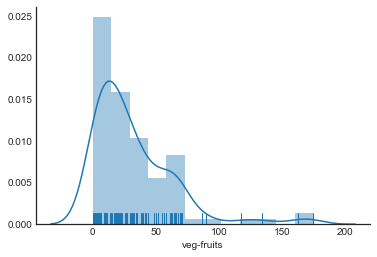

In [12]:
crop_type = 'veg-fruits'
sns.distplot(trials[crop_type]-targets.loc[region, crop_type], rug=True)
sns.despine()

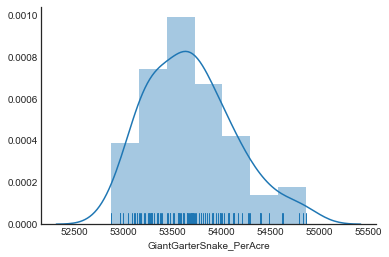

In [13]:
sns.distplot(trials['GiantGarterSnake_PerAcre'], rug=True)
sns.despine()